# Frontal Detection Analysis (superimpose climate fields on frontal ID maps)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
file_path = "/glade/work/kdagon/FrontDetector/CESMOutputs/"

In [3]:
fronts_file = "cesm_fronts_2000-2005.nc"
onehot_file = "cesm_frontsOneHot_2000-2005.nc"
rates_file = "cesm_frontRates_2000-2005.nc"

## Read in predicted fronts file

In [4]:
pred_fronts = xr.open_dataset(file_path+fronts_file)

In [5]:
pfronts = pred_fronts.predicted_fronts

## Read in "onehot" fronts file

In [6]:
onehot = xr.open_dataset(file_path+onehot_file)

In [7]:
fronts = onehot.fronts

In [8]:
allfronts = fronts.argmax(dim='front')

In [9]:
allfronts

<xarray.DataArray 'fronts' (time: 17520, lat: 68, lon: 141)>
array([[[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       ...,

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]],

       [[4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]]])
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
  * lon      (lon) float64 189.0 190.0 191.0 192.0 ... 326.0 327.0 328.0 329.0

## Read in sea level pressure field

In [10]:
#cesm_file_path = "/glade/campaign/cgd/ccr/kdagon/dlfront/"

In [11]:
#PSL = xr.open_mfdataset(cesm_file_path+'*PSL*', combine='by_coords')

In [12]:
#SLP = PSL.PSL

In [13]:
#SLP[0,:,:]

## Superimpose two fields

In [14]:
import matplotlib.colors 
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [15]:
# making a custom colorbar with blue for cold, red for warm, grey for stationary, 
# purple for occluded, and white for none fronts.

cmap_all = matplotlib.colors.ListedColormap(['blue', 'red', 'grey', 'purple', 'w'])
bounds = [0, 0.99, 1.99, 2.99, 3.99, 4.99]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap_all.N)

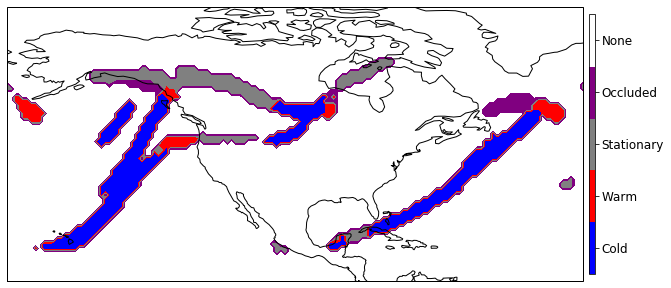

In [16]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree())
#ax = fig.add_subplot(projection=ccrs.PlateCarree())

field, lon = add_cyclic_point(allfronts[0,:,:], coord=allfronts.lon)
lat = allfronts.lat
cf = ax.contourf(lon, lat, field, cmap=cmap_all, vmin=0, vmax=4.99, levels=bounds, transform=ccrs.PlateCarree())

#field, lon = add_cyclic_point(SLP[0,:,:], coord=SLP.lon)
#c = ax.contour(lon, lat, field, transform=ccrs.PlateCarree())

ax.coastlines()

import matplotlib as mpl
cbar_ax = fig.add_axes([1.01, 0.2, 0.01, 0.6])
norm = mpl.colors.Normalize(vmin=0, vmax=4.99)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, 
                                cmap=cmap_all,
                                norm=norm,
                                orientation='vertical', 
                               ticks=bounds)
labels = np.array([0, 0.99, 1.99, 2.99, 3.99])
loc    = labels + .5
tick_1 = ['Cold','Warm','Stationary','Occluded','None']
cb1.set_ticks(loc)
cb1.ax.set_yticklabels(tick_1)
cb1.ax.tick_params(labelsize=12)

#cbar.set_ticklabels(['Cold','Warm','Occluded','None'])

#cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap_all, norm=norm)
#ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
#cb = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap_all, norm=norm,
#    spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')